# MILVUS Demo - Binary Embedding

# Use Binary Embedding to Search Using Milvus in watsonx.data

## Disclaimers
- Use only Projects and Spaces that are available in watsonx context.

## Overview
### Audience
This notebook demonstrates how to implement Binary Embedding.
Binary embeddings are compressed vector representations where each dimension is stored as a single bit (0 or 1) instead of floating-point numbers.
The scenario presented in this notebook shows how to use Binary embeddings during search.

Some familiarity with Python programming, search algorithms, and basic machine learning concepts is recommended. The code runs with Python 3.10 or later.
### Learning goal
This notebook demonstrates Milvus Binary Embedding support in watsonx.data, introducing commands for:
- Connecting to Milvus
- Creating collections
- Creating indexes
- Generate Embeddings
- Ingesting data
- Data retrieval


### About Milvus 

Milvus is an open-source vector database designed specifically for scalable similarity search and AI applications. It's a powerful platform that enables efficient storage, indexing, and retrieval of vector embeddings, which are crucial in modern machine learning and artificial intelligence tasks.[ To know more, visit Milvus Documentation](https://www.ibm.com/docs/en/watsonx/watsonxdata/2.1.x?topic=components-milvus)

### Milvus: Three Fundamental Steps

#### 1. Data Preparation
Collect and convert your data into high-dimensional vector embeddings. These vectors are typically generated using machine learning models like neural networks, which transform text, images, audio, or other data types into dense numerical representations that capture semantic meaning and relationships.

#### 2. Vector Insertion
Load the dense vector embeddings and sparse vector embeddings into Milvus collections or partitions within a database. Milvus creates indexes to optimize subsequent search operations, supporting various indexing algorithms like IVF-FLAT, HNSW, etc., based on the definition.

#### 3. Similarity Search
Perform vector similarity searches by providing a query vector and a reranking weight. Milvus will rapidly return the most similar vectors from the collection or partitions based on the defined metrics like cosine similarity, Euclidean distance, or inner product and the reranking weight.

### What is Binary Embedding?
Binary embeddings are compressed vector representations where each dimension is stored as a single bit (0 or 1) instead of floating-point numbers. Binary embeddings are stored as BINARY_VECTOR data types and can be indexed using specialized indexing methods like BIN_FLAT and BIN_IVF_FLAT. In scenarios where memory optimization is a priority, speed is more important than accuracy or data is naturally binary this could be used.

### Key Workflow

1. **Definition** (once)
2. **Ingestion** (once)
3. **Retrieve relevant passage(s)** (for every user query)

## Contents

- Environment Setup
- Install packages
- Document data loading
- Create connection
- Ingest data
- Retrieve relevant data

## Environment Setup
Before using the sample code in this notebook, complete the following setup tasks:

- Create a Watsonx.data instance (a free plan is offered)
  - Information about creating a watsonx.data instance can be found [here](https://www.ibm.com/docs/en/watsonx/watsonxdata/2.0.x)

## Install required packages

In [20]:
%%capture
!pip install numpy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
%%capture
!pip install torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
%%capture
!pip install sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Install Pymilvus SDK

In [23]:
# !pip install pymilvus
# Restart Kernal
%pip show pymilvus

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Name: pymilvus
Version: 2.5.3
Summary: Python Sdk for Milvus
Home-page: 
Author: 
Author-email: Milvus Team <milvus-team@zilliz.com>
License: 
Location: /opt/homebrew/lib/python3.11/site-packages
Requires: grpcio, milvus-lite, pandas, protobuf, python-dotenv, setuptools, ujson
Required-by: 
Note: you may need to restart the kernel to use updated packages.


### Import required packages

In [24]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Binarizer
import numpy as np
from sentence_transformers import SentenceTransformer
import sys
from pymilvus import utility

## Preparing data

In [25]:

data = [
    {"question": "what if i forget my credential?", "answer": "if you forget your credential, reset it by going to the settings page and clicking on 'Reset credentials'."},
    {"question": "what is the format a password should follow ?", "answer": "a password should have atleast 8 characters which includes letters, signs and numbers."},        
    {"question": "What are the shipping options?", "answer": "We offer standard, expedited, and same-day shipping options."},
    {"question": "How do I track my order?", "answer": "To track your order, visit the 'Order History' section in your account."},
    {"question": "What is the return policy?", "answer": "You can return items within 30 days of purchase, as long as they are in original condition."},
    {"question": "How can I contact customer support?", "answer": "You can reach customer support by emailing support@company.com or calling 1-800-123-4567."},
    {"question": "What payment methods are accepted?", "answer": "We accept credit cards, debit cards, and PayPal."},
    {"question": "how to reset username?", "answer": " reset username by going to the settings page and clicking on 'Reset credentials'. click 'Reset username'"},
    {"question": "How do I cancel my order?", "answer": "To cancel your order, go to 'Order History' and click 'Cancel Order' before it ships."},
    {"question": "Are gift cards available?", "answer": "Yes, you can purchase gift cards in denominations of $25, $50, $100, and more."},
    {"question": "Can I change my shipping address?", "answer": "Yes, you can update your shipping address before the order is shipped."},
    {"question": "Do you ship internationally?", "answer": "Yes, we ship to over 50 countries worldwide. Shipping rates may vary."},
    {"question": "Is there a loyalty program?", "answer": "Yes, members earn points on every purchase which can be redeemed for discounts."},
    {"question": "How do I report a damaged item?", "answer": "Contact customer support with a photo of the damaged item within 7 days of receipt."},
    {"question": "Can I expedite my order?", "answer": "Yes, choose expedited shipping during checkout for faster delivery."},
    {"question": "What is the warranty policy?", "answer": "Products come with a one-year warranty. Some exclusions apply."},
    {"question": "How do I unsubscribe from newsletters?", "answer": "Click the 'Unsubscribe' link at the bottom of any newsletter email."},
    {"question": "Do you have a mobile app?", "answer": "Yes, download our app from the App Store or Google Play for a better shopping experience."}, 
    {"question": "Can I preorder items?", "answer": "Yes, items available for preorder will be marked on the product page."},
    {"question": "How do I update my account information?", "answer": "Go to the 'Account Settings' page to update your personal information."},
    {"question": "Can I schedule a delivery time?", "answer": "Delivery scheduling is available for select products. Check during checkout."},
    {"question": "Do you offer price matching?", "answer": "Yes, we match competitor prices on identical items. Contact support for details."},
    {"question": "Can I buy items in bulk?", "answer": "Yes, we offer bulk discounts for select items. Contact sales for pricing."},
    {"question": "How do I apply a promo code?", "answer": "Enter your promo code at checkout in the designated field before completing your purchase."},
    {"question": "Can I split my payment between multiple cards?", "answer": "Currently, we do not support split payments between multiple credit cards."},
    {"question": "What happens if an item is out of stock?", "answer": "If an item is out of stock, you can sign up for a notification when it becomes available again."},
    {"question": "How do I delete my account?", "answer": "To delete your account, please contact customer support for assistance."},
    {"question": "Do you offer financing options?", "answer": "Yes, we offer financing through our partner services. Check eligibility at checkout."},
    {"question": "How do I request a refund?", "answer": "Refunds can be requested through 'Order History' or by contacting customer support."},
    {"question": "What should I do if I received the wrong item?", "answer": "If you received the wrong item, contact support to arrange a return and replacement."},
    {"question": "Are there any subscription services?", "answer": "Yes, we offer subscription services for select products with discounts for recurring deliveries."},
    {"question": "Can I update my payment method?", "answer": "Yes, go to 'Account Settings' and update your payment information."},
    {"question": "Do you offer eco-friendly packaging?", "answer": "Yes, we have eco-friendly packaging options for select products."},
    {"question": "Is gift wrapping available?", "answer": "Yes, you can add gift wrapping to your order at checkout."},
    {"question": "How do I refer a friend?", "answer": "Use your referral link to invite friends and earn rewards when they make a purchase."},
    {"question": "What security measures do you have for my data?", "answer": "We use encryption and secure servers to protect your personal information."},
    {"question": "How do I sign up for text notifications?", "answer": "You can enable text notifications in your account settings."},
    {"question": "Are there any student discounts?", "answer": "Yes, students can verify their status to receive exclusive discounts."},
    {"question": "How do I become an affiliate?", "answer": "Apply for our affiliate program on our website to earn commissions on referrals."},
    {"question": "Can I customize my order?", "answer": "Some items allow customization. Check the product page for options."},
    {"question": "What happens if my package is lost?", "answer": "Contact customer support to start an investigation and request a replacement or refund."}
]


# Convert  dataset to a DataFrame
df = pd.DataFrame(data)
df.head(5)


,question,answer
0,what if i forget my credential?,"if you forget your credential, reset it by goi..."
1,what is the format a password should follow ?,a password should have atleast 8 characters wh...
2,What are the shipping options?,"We offer standard, expedited, and same-day shi..."
3,How do I track my order?,"To track your order, visit the 'Order History'..."
4,What is the return policy?,You can return items within 30 days of purchas...


### Generating  embeddings

#### 1. Binary embedding

In [26]:
# Convert Text to TF-IDF Vectors
vectorizer = TfidfVectorizer(max_features=128)
question_embeddings = vectorizer.fit_transform(df['question']).toarray()

In [27]:
# Convert TF-IDF Vectors to Binary Vectors
binarizer = Binarizer(threshold=0.5)
binary_question_embeddings = binarizer.transform(question_embeddings)

In [28]:
def convert_to_byte_array(binary_vector):
    if len(binary_vector) % 8 != 0:
        padding_length = (8 - len(binary_vector) % 8) % 8
        binary_vector = np.pad(binary_vector, (0, padding_length), mode='constant', constant_values=0)
    byte_array = bytearray(len(binary_vector) // 8)
    for i, bit in enumerate(binary_vector):
        if bit == 1:
            index = i // 8
            shift = i % 8
            byte_array[index] |= (1 << shift)
    return bytes(byte_array)

binary_question_embeddings_bytes = [convert_to_byte_array(bin_emb) for bin_emb in binary_question_embeddings]
df['binary_question_embedding'] = binary_question_embeddings_bytes
df.head(5)

,question,answer,binary_question_embedding
0,what if i forget my credential?,"if you forget your credential, reset it by goi...",b'\x00\x00\x10\x00\x04\x00\x00\x00\x00\x00\x00...
1,what is the format a password should follow ?,a password should have atleast 8 characters wh...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
2,What are the shipping options?,"We offer standard, expedited, and same-day shi...",b'\x00\x00\x00\x00\x00\x00\x00\x80\x00\x00@\x0...
3,How do I track my order?,"To track your order, visit the 'Order History'...",b'\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00...
4,What is the return policy?,You can return items within 30 days of purchas...,b'\x00\x00\x00\x00\x00\x00\x00\x00@\x00\x02\x0...


#### 2. Dense vector embedding

In [29]:
# Generate Dense Vector Embeddings
sentence_transformer_model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_transformer_embeddings = sentence_transformer_model.encode(df['question'].tolist())
df['sentence_transformer_embedding'] = list(sentence_transformer_embeddings)
df.head(5)

,question,answer,binary_question_embedding,sentence_transformer_embedding
0,what if i forget my credential?,"if you forget your credential, reset it by goi...",b'\x00\x00\x10\x00\x04\x00\x00\x00\x00\x00\x00...,"[-0.05695605, -0.016203597, 0.0060177078, 0.02..."
1,what is the format a password should follow ?,a password should have atleast 8 characters wh...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,"[0.011928552, 0.0060997354, -0.12134363, -0.09..."
2,What are the shipping options?,"We offer standard, expedited, and same-day shi...",b'\x00\x00\x00\x00\x00\x00\x00\x80\x00\x00@\x0...,"[-0.0145034725, 0.020202648, 0.035312906, 0.07..."
3,How do I track my order?,"To track your order, visit the 'Order History'...",b'\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00...,"[0.01565075, -0.062447622, 0.03897734, 0.00335..."
4,What is the return policy?,You can return items within 30 days of purchas...,b'\x00\x00\x00\x00\x00\x00\x00\x00@\x00\x02\x0...,"[-0.03421611, 0.0654714, 0.026852747, 0.013523..."


### Comparing the memory usage - binary embedding v/s dense vector embedding

In [30]:
def calculate_memory_usage(column):
    return sum(sys.getsizeof(item) for item in column)

tfidf_memory_usage = calculate_memory_usage(df['binary_question_embedding'])
sentence_transformer_memory_usage = calculate_memory_usage(df['sentence_transformer_embedding'])

print(f"Memory usage of TF-IDF binary embeddings: {tfidf_memory_usage} bytes")
print(f"Memory usage of Sentence Transformer embeddings: {sentence_transformer_memory_usage} bytes")

Memory usage of TF-IDF binary embeddings: 1927 bytes
Memory usage of Sentence Transformer embeddings: 4592 bytes


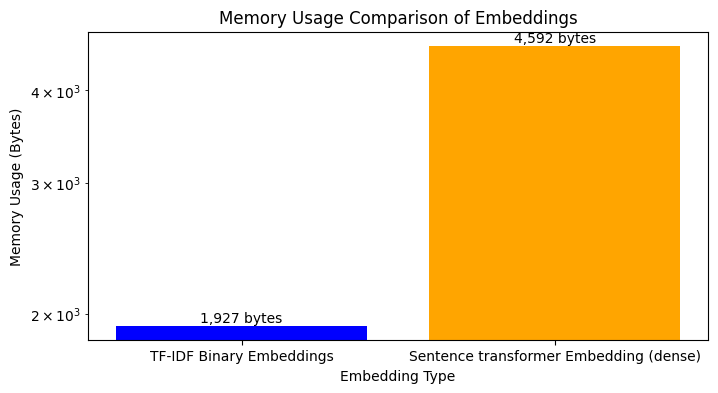

In [31]:
import matplotlib.pyplot as plt
# Create a bar chart to visualize memory usage
embedding_types = ['TF-IDF Binary Embeddings', 'Sentence transformer Embedding (dense)']
memory_usages = [tfidf_memory_usage, sentence_transformer_memory_usage]

plt.figure(figsize=(8, 4))
plt.bar(embedding_types, memory_usages, color=['blue', 'orange'])
plt.title('Memory Usage Comparison of Embeddings')
plt.xlabel('Embedding Type')
plt.ylabel('Memory Usage (Bytes)')
plt.yscale('log')  # Use log scale for better visualization if memory usage varies significantly
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add memory usage values on top of the bars
for i, value in enumerate(memory_usages):
    plt.text(i, value, f'{value:,} bytes', ha='center', va='bottom')

plt.show()

### Connect to Milvus

In [ ]:
from pymilvus import connections, Collection, FieldSchema, DataType, CollectionSchema

# Replace Placeholder Values <> with respective provisioned Milvus Values .
"""# On Prem
connections.connect(
            alias='default',
            host="<>",
            port=443,
            secure=True,
            server_pem_path="",
            server_name="<>",
            user="<>",
            password="<>")
# SaaS
connections.connect(
            alias='default',
            host="<>",
            port="<>",
            secure=True,
            user="<>",
            password="<>")"""
print("milvus connected")



milvus connected


### Create Milvus Schema and Collection

In [33]:
collection_name = "customer_support_chatbot"
if utility.has_collection(collection_name):
    utility.drop_collection(collection_name)

fields = [
    FieldSchema(name="question", dtype=DataType.VARCHAR, is_primary=True, max_length=1048, description="The question text"),
    FieldSchema(name="answer", dtype=DataType.VARCHAR, max_length=1048),
    FieldSchema(name="binary_question_embedding", dtype=DataType.BINARY_VECTOR, dim=112, description="The binary embedding of the question"),
]

schema = CollectionSchema(fields, description="Customer support chatbot question binary embeddings")
collection = Collection(name=collection_name, schema=schema)
print("collection created")

collection created


### Insert data

In [34]:
data = [
    df['question'].tolist(),  # Questions
    df['answer'].tolist(),
    [embedding for embedding in df['binary_question_embedding'].tolist()]  # Binary embeddings
]
collection.insert(data)

(insert count: 41, delete count: 0, upsert count: 0, timestamp: 456274223101378564, success count: 41, err count: 0

### create index and load data

In [35]:
index_params = {
    "metric_type": "HAMMING",  # Metric type for binary vectors
    "index_type": "BIN_IVF_FLAT",  # Index type for binary vectors
    "params": {"nlist": 128}  # Index parameter
}
collection.create_index(field_name="binary_question_embedding", index_params=index_params)
collection.load()

### Search with Binary Embeddings

In [36]:
query_question = "i forgot my credential?"
query_embedding = vectorizer.transform([query_question]).toarray()
binary_query_embedding = binarizer.transform(query_embedding)[0]
binary_query_embedding_bytes = convert_to_byte_array(binary_query_embedding)

search_params = {"metric_type": "HAMMING", "params": {"nprobe": 16}}
results = collection.search(
    data=[binary_query_embedding_bytes], 
    anns_field="binary_question_embedding",
    param=search_params,
    limit=3,  # Limit to 3 closest matches
    output_fields=["question", "binary_question_embedding", "answer"]
)

print("\nQuery:", query_question)
print("\nSearch Results (Binary Embeddings):")
for hit in results[0]:
    print(f"Answer: {hit.entity.get('answer')}, Distance: {hit.distance}")


Query: i forgot my credential?

Search Results (Binary Embeddings):
Answer: if you forget your credential, reset it by going to the settings page and clicking on 'Reset credentials'., Distance: 1.0
Answer: a password should have atleast 8 characters which includes letters, signs and numbers., Distance: 1.0
Answer: Yes, we offer bulk discounts for select items. Contact sales for pricing., Distance: 1.0


### Search with Sentence Transformer Embeddings

In [37]:
query_embedding_st = sentence_transformer_model.encode([query_question])[0]

# Create a new collection for Sentence Transformer embeddings
collection_name_st = "customer_support_chatbot_st"
if utility.has_collection(collection_name_st):
    utility.drop_collection(collection_name_st)

fields_st = [
    FieldSchema(name="question", dtype=DataType.VARCHAR, is_primary=True, max_length=1048, description="The question text"),
    FieldSchema(name="answer", dtype=DataType.VARCHAR, max_length=1048),
    FieldSchema(name="sentence_transformer_embedding", dtype=DataType.FLOAT_VECTOR, dim=384, description="The Sentence Transformer embedding of the question"),
]

schema_st = CollectionSchema(fields_st, description="Customer support chatbot question Sentence Transformer embeddings")
collection_st = Collection(name=collection_name_st, schema=schema_st)
print("collection for Sentence Transformer embeddings created")

# Insert data into the new collection
data_st = [
    df['question'].tolist(),  # Questions
    df['answer'].tolist(),
    [embedding for embedding in df['sentence_transformer_embedding'].tolist()]  # Sentence Transformer embeddings
]
collection_st.insert(data_st)

# Create index for Sentence Transformer embeddings
index_params_st = {
    "metric_type": "L2",  # Metric type for dense vectors
    "index_type": "IVF_FLAT",  # Index type for dense vectors
    "params": {"nlist": 128}  # Index parameter
}
collection_st.create_index(field_name="sentence_transformer_embedding", index_params=index_params_st)
collection_st.load()

# Perform the search with Sentence Transformer embeddings
search_params_st = {"metric_type": "L2", "params": {"nprobe": 16}}
results_st = collection_st.search(
    data=[query_embedding_st], 
    anns_field="sentence_transformer_embedding",
    param=search_params_st,
    limit=3,  # Limit to 3 closest matches
    output_fields=["question", "sentence_transformer_embedding", "answer"]
)

print("\nSearch Results (Sentence Transformer Embeddings):")
for hit in results_st[0]:
    print(f"Answer: {hit.entity.get('answer')}, Distance: {hit.distance}")

collection for Sentence Transformer embeddings created

Search Results (Sentence Transformer Embeddings):
Answer: if you forget your credential, reset it by going to the settings page and clicking on 'Reset credentials'., Distance: 0.2657339572906494
Answer:  reset username by going to the settings page and clicking on 'Reset credentials'. click 'Reset username', Distance: 1.1546971797943115
Answer: Go to the 'Account Settings' page to update your personal information., Distance: 1.2811033725738525


### Comparison of search results

In [38]:

print("\nComparison of Search Results:")
print("\nQuery: ",query_question)
print("\nBinary Embeddings:")
for hit in results[0]:
    print(f"Answer: {hit.entity.get('answer')}, Distance: {hit.distance}")

print("\nSentence Transformer Embeddings:")
for hit in results_st[0]:
    print(f"Answer: {hit.entity.get('answer')}, Distance: {hit.distance}")


Comparison of Search Results:

Query:  i forgot my credential?

Binary Embeddings:
Answer: if you forget your credential, reset it by going to the settings page and clicking on 'Reset credentials'., Distance: 1.0
Answer: a password should have atleast 8 characters which includes letters, signs and numbers., Distance: 1.0
Answer: Yes, we offer bulk discounts for select items. Contact sales for pricing., Distance: 1.0

Sentence Transformer Embeddings:
Answer: if you forget your credential, reset it by going to the settings page and clicking on 'Reset credentials'., Distance: 0.2657339572906494
Answer:  reset username by going to the settings page and clicking on 'Reset credentials'. click 'Reset username', Distance: 1.1546971797943115
Answer: Go to the 'Account Settings' page to update your personal information., Distance: 1.2811033725738525


### Conclusion
Binary embeddings are more memory-efficient; however, they come at the cost of accuracy. As shown in the results below, the responses retrieved using binary embeddings are less relevant to the query compared to those from other alternative approach.

Disclaimer - Results are subject to chamge based on quality ad quantity of your dataset. for large datasets with lot of similar text, the accuracy trade off may not be visible